In [1]:
import pandas as pd
import numpy as np
import itertools
from scipy import linalg

from sklearn.neighbors.kde import KernelDensity
from sklearn import mixture
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering

import matplotlib.pyplot as plt
import matplotlib as mpl
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [2]:
dfb0 = pd.read_pickle('data/TorontoBusiness.pkl.gz')

In [11]:
class ClusteringClass:
    def __init__(self,dfb0):
        self.dfb0 = dfb0
        self.Xf = np.array(self.dfb0[['longitude','latitude']])
        
        kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(self.Xf)
        self.scrs = kde.score_samples(self.Xf)
        self.dfb0['scr_0'] = self.scrs
        
        self.color_iter = itertools.cycle(['plum','peachpuff','lightsalmon', 'c', 'cornflowerblue', 'gold',
                              'darkorange', 'lightcoral','yellowgreen',
                              'lightgreen','dodgerblue','green'])
        
        self.street_map = gpd.read_file('topo_edge_of_road_wgs84/TOPO_EDGE_OF_ROAD_WGS84.shp')
        
    def exclude_outliers(self,Radius):
        self.X = self.Xf[self.scrs >= Radius,:]
        X1 = self.Xf[self.scrs < Radius,:]
        plt.scatter(self.X[:,0],self.X[:,1], alpha = 0.05)
        plt.scatter(X1[:,0],X1[:,1], alpha = 0.05, color = 'red')
        plt.title('Outliers')
    
    def get_patch(self, ax, mean, covar, color):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.4)
        
        return ell
    
    def plot_clusters(self, title='Clusters', streets=True, print_id=True):
        fig, ax = plt.subplots(figsize=(12,12))
        if streets:
            self.street_map.plot(ax = ax, alpha = 1, color = 'grey')
        for i, (mean, covar, color) in enumerate(zip(self.means_, self.covariances_, self.color_iter)):
            if not np.any(self.Y_ == i):
                continue
            ax.scatter(self.X[self.Y_ == i, 0], self.X[self.Y_ == i, 1], 5, color=color, alpha = 0.4)
            
            if print_id:
                ax.text(mean[0],mean[1], str(i) )

            ax.add_artist(self.get_patch(ax, mean, covar, color))
            plt.title(title, fontsize=20)
            
    def cluster_gaussians(self):
        self.means_ = np.zeros([self.N_clusters,2])
        self.covariances_ = np.zeros([self.N_clusters,2,2])
        for i in range(self.N_clusters):
            Xi = self.X[self.Y_ == i, :]
            self.means_[i,:] = [np.mean(Xi[:,0]),np.mean(Xi[:,1])]
            self.covariances_[i,:,:]  = np.cov(np.transpose(Xi))
        
            
    def gmm_(self, N_clusters = 60):
        self.N_clusters = N_clusters
        gmm = mixture.GaussianMixture(n_components=N_clusters, covariance_type='full')
        gmm.fit(self.X)
        self.Y_ = gmm.predict(self.X)
        self.means_ = gmm.means_
        self.covariances_ = gmm.covariances_
    
    def bgmm_(self, N_clusters = 60):
        self.N_clusters = N_clusters
        bgmm = mixture.BayesianGaussianMixture(n_components=N_clusters, covariance_type='full', 
                                      weight_concentration_prior = 1, n_init = 5, max_iter = 1000, tol = 1e-3)
        bgmm.fit(self.X)
        self.Y_ = bgmm.predict(self.X)
        self.means_ = bgmm.means_
        self.covariances_ = bgmm.covariances_
    
    def kmeans_(self, N_clusters = 60, plot_=True):
        self.N_clusters = N_clusters
        kmeans = KMeans(n_clusters=N_clusters, random_state=0).fit(self.X)
        self.Y_ = kmeans.predict(self.X)
        self.cluster_gaussians()

    
    def agglo_(self, N_clusters = 60, plot_=True):
        self.N_clusters = N_clusters
        self.Y_ = AgglomerativeClustering(n_clusters=N_clusters).fit_predict(self.X)
        self.cluster_gaussians()

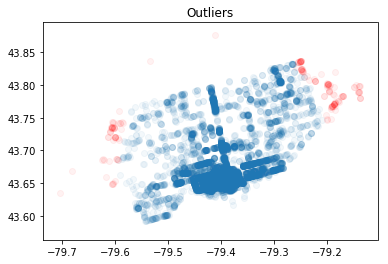

In [12]:
cls = ClusteringClass(dfb0)
cls.exclude_outliers(0.85)

# Bayesian Gaussian Mixture

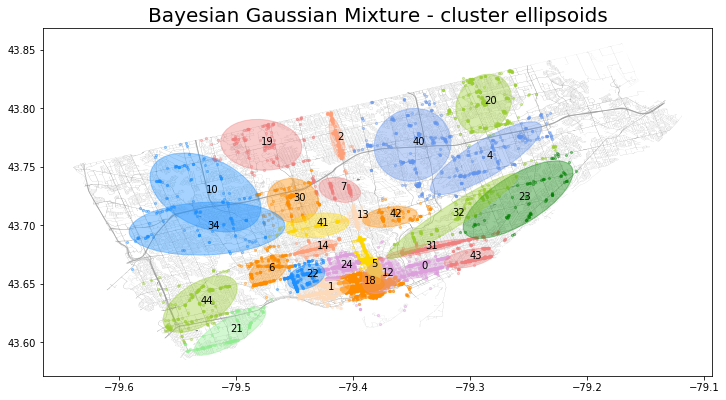

In [5]:
cls.bgmm_(N_clusters=60)
cls.plot_clusters(title = 'Bayesian Gaussian Mixture - cluster ellipsoids')

# Gaussian Mixture

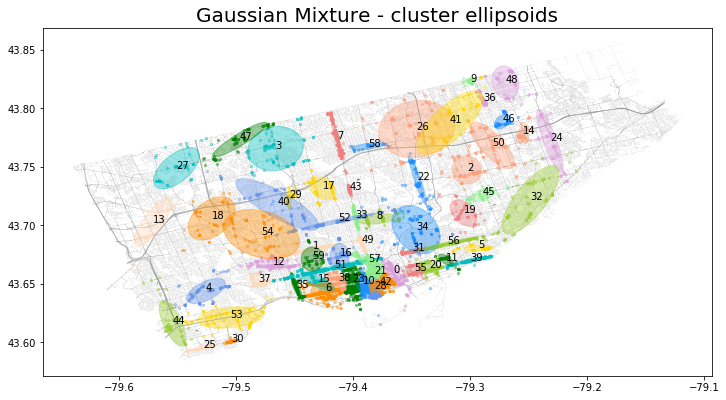

In [6]:
cls.gmm_(N_clusters=60)
cls.plot_clusters(title = 'Gaussian Mixture - cluster ellipsoids')

# K-Means clustering

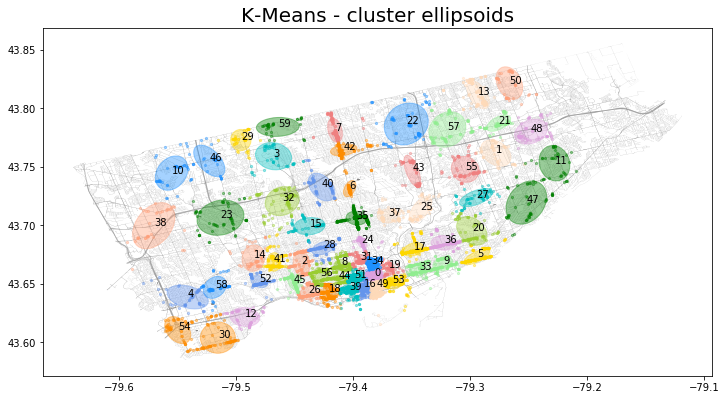

In [13]:
cls.kmeans_(N_clusters=60)
cls.plot_clusters(title = 'K-Means - cluster ellipsoids')

# Agglomerative clustering

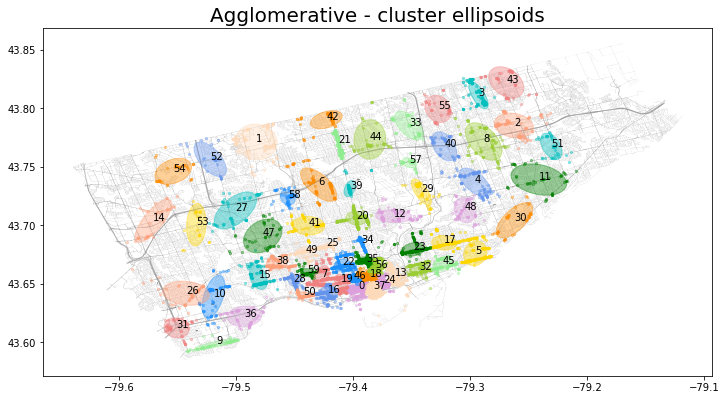

In [14]:
cls.agglo_(N_clusters=60)
cls.plot_clusters(title = 'Agglomerative - cluster ellipsoids')